# Time series forecasting with DeepAR - eCommerce Data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

In [4]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

In [5]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket and prefix that we want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to the data. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [14]:
bucket = 'sagemaker-2018sep16'
prefix = 'sagemaker/Digicast'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

Read csv data from data folder

In [16]:
#Read csv to dataframe
df_ts = pd.read_csv("data/timeseries.csv", index_col=0)
#Convert index to Datetime
df_ts.index = pd.to_datetime(df_ts.index)

In [17]:
df_ts.fillna(0, inplace=True)
df_ts.head()

85123A  71053  84406B  84029G  84029E  22752  21730  22633  22632  \
2010-12-01   441.0   32.0    40.0    56.0   549.0   22.0   30.0  178.0  232.0   
2010-12-02   308.0   94.0    85.0   134.0   135.0  219.0   73.0  151.0  162.0   
2010-12-03    20.0    0.0     0.0     4.0    16.0    6.0    3.0  102.0   26.0   
2010-12-04     0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0   
2010-12-05   198.0    0.0    33.0    29.0    17.0    8.0    2.0   80.0   73.0   

            84879  ...    23576  23562  23561  90214F  90214O  90214T  90214U  \
2010-12-01  216.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-02  503.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-03   32.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-04    0.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2010-12-05  128.0  ...      0.0    0.0    0.0     0.0     0.0     0.0     0.0   

            90214W  90214Z  90089  
2010-12-01     0.0     0.0    0.0  
2010-12-02     0.0     0.0    0.0  
2010-12-03     0.0     0.0    0.0  
2010-12-04     0.0     0.0    0.0  
2010-12-05     0.0     0.0    0.0  

[5 rows x 3651 columns]

Intialise all required values 

In [18]:
#Define various values. All these are not used here but kept for understanding.
freq = 'D'
prediction_length = 14 #Two weeks 
context_length = 60 #Two months
t0 = '2010-12-01 00:00:00' #Start date of our dataframe
data_length = 374
num_ts = 3651

Convert time series dataframe to list of time series 

In [19]:
time_series = []
df_ts.apply(lambda x: time_series.append(pd.Series(data=x.tolist(), index=df_ts.index)))
time_series[0].head()

2010-12-01    441.0
2010-12-02    308.0
2010-12-03     20.0
2010-12-04      0.0
2010-12-05    198.0
dtype: float64

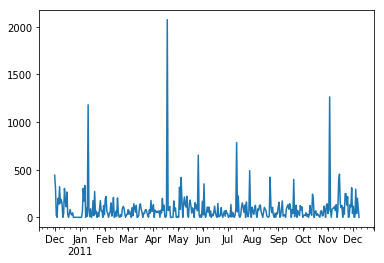

In [9]:
time_series[0].plot()
plt.show()

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

We will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict 14 data points, therefore we take out the trailing 14 points from each time series to define the training set. The test set contains the full range of each time series.

In [20]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

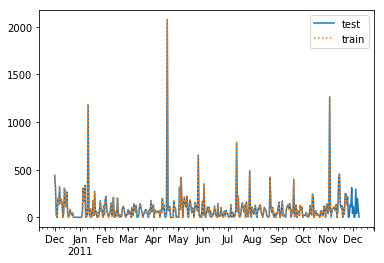

In [21]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [22]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [14]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Train a model

We can now define the estimator that will launch the training job.

In [15]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='Digicast-deepar',
    output_path="s3://" + s3_output_path
)

Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [16]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "10",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [17]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [18]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: Digicast-deepar-2018-09-16-10-54-43-786


....................
Arguments: train
[09/16/2018 10:57:56 INFO 139682222380864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[09/16/2018 10:57:56 INFO 139682222380864] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'14', u'epochs': u'10', u'time_freq': u'D', u'context_length': u'60', u'num_layers': u'3', u'mini_batch_size': u'3

### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [11]:
#job_name = estimator.latest_training_job.name
job_name = 'Digicast-deepar-2018-09-16-10-54-43-786'

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating endpoint with name Digicast-deepar-2018-09-16-10-54-43-786


--------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [23]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #Modified this one line of code to take care of error - Cannot add integral value to Timestamp without freq.
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.asfreq(self.freq).index[-1]+1 for x in ts]
        
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        
        #Added to see request being sent
        print("req:")
        print(req)
        
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        
        #Added to see response returned
        print("response:")
        print(response)
        
        response_data = json.loads(response.decode(encoding))
        
        #Added to see response returned
        print("response_data:")
        print(response_data)
        
        
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [24]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [25]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

req:
b'{"instances": [{"start": "2010-12-01 00:00:00", "target": [441.0, 308.0, 20.0, 0.0, 198.0, 136.0, 321.0, 149.0, 188.0, 152.0, 0.0, 42.0, 303.0, 185.0, 111.0, 266.0, 32.0, 0.0, 42.0, 83.0, 35.0, 24.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 304.0, 171.0, 334.0, 0.0, 97.0, 12.0, 1180.0, 79.0, 6.0, 89.0, 0.0, 23.0, 174.0, 18.0, 271.0, 36.0, 63.0, 0.0, 47.0, 8.0, 89.0, 175.0, 64.0, 67.0, 0.0, 123.0, 28.0, 193.0, 218.0, 59.0, 42.0, 0.0, 35.0, 58.0, 151.0, 13.0, 66.0, 209.0, 0.0, 6.0, 64.0, 12.0, 203.0, 50.0, 6.0, 0.0, 28.0, 11.0, 92.0, 115.0, 96.0, 30.0, 0.0, 27.0, 29.0, 82.0, 33.0, 66.0, 27.0, 0.0, 101.0, 17.0, 142.0, 98.0, 54.0, 125.0, 0.0, 3.0, 19.0, 114.0, 141.0, 85.0, 55.0, 0.0, 45.0, 38.0, 77.0, 82.0, 52.0, 21.0, 0.0, 77.0, 43.0, 177.0, 61.0, 68.0, 133.0, 0.0, 76.0, 65.0, 50.0, 64.0, 50.0, 68.0, 0.0, 74.0, 45.0, 198.0, 73.0, 127.0, 8.0, 0.0, 23.0, 2073.0, 72.0, 73.0, 115.0, 0.0, 0.0, 0.0, 0.0, 172.0, 67.0, 98.0, 0.0, 0.0, 12.0, 0.0, 316.0, 85.0, 418.0

In [35]:
list_of_df[0]

0.1         0.5         0.9
2010-12-01 -285.953491  119.261604  547.986877
2010-12-02 -181.258804  219.052887  609.487793
2010-12-03 -272.989349  148.372589  606.009888
2010-12-04 -236.890244  129.909698  619.263428
2010-12-05 -174.157349  198.007675  554.751343
2010-12-06 -373.840851   90.033875  707.964355
2010-12-07 -223.268372  169.256485  478.641083
2010-12-08 -197.919113   58.931782  353.143219
2010-12-09 -176.466599  109.279320  354.442688
2010-12-10 -215.476746  131.725342  516.619202
2010-12-11 -273.425751  184.817413  618.807007
2010-12-12 -274.888336  152.022537  455.532227
2010-12-13 -286.275574   80.566124  418.327423
2010-12-14 -214.921722   98.089615  430.680420

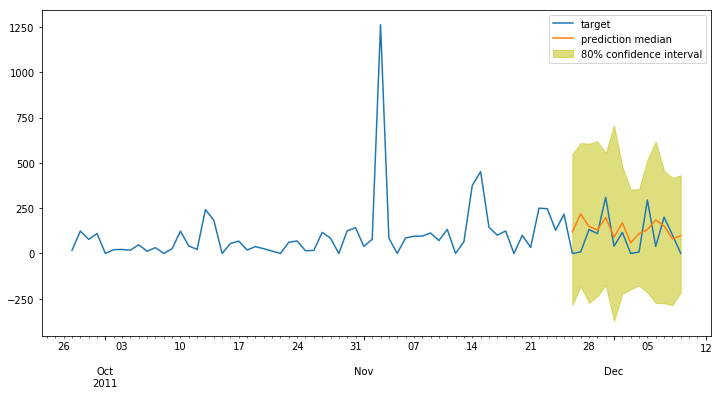

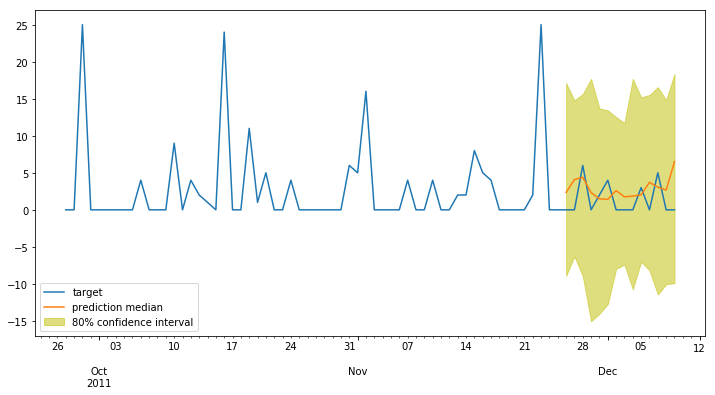

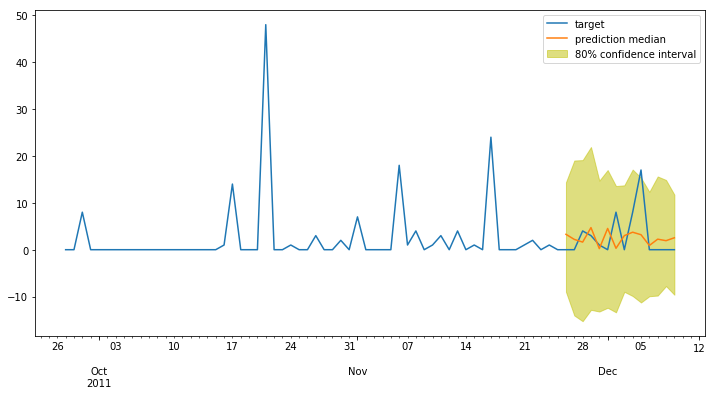

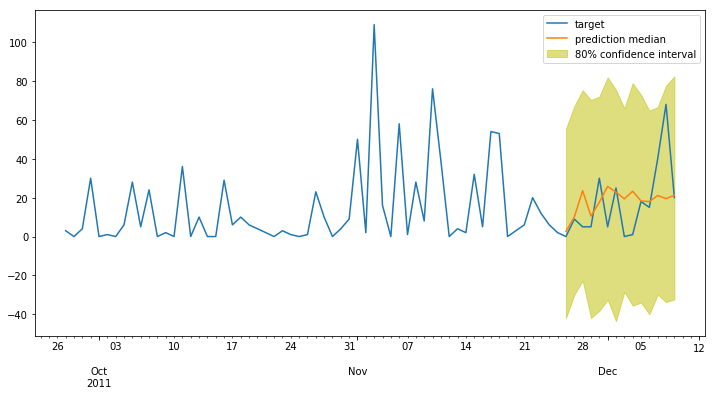

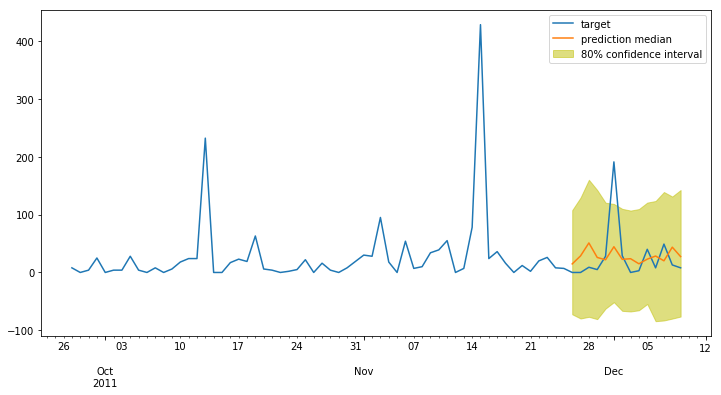

In [17]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Delete endpoint

In [38]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: Digicast-deepar-2018-09-16-10-54-43-786
